In [1]:
import os
from utils import load_jsonl_iteratively, load_jsonl
from memorization_analysis.utils import get_model_loss

In [54]:
from tqdm import tqdm
ja_mem_id2losses, ja_gen_id2losses, en2ja_gen_id2losses = {}, {}, {}
for i in tqdm(range(0, 17000, 1000)):
    i = 'last' if i == 16000 else i
    id2loss = get_model_loss("ja", "generalization", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        ja_gen_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])
    
    id2loss = get_model_loss("ja", "memorization", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        ja_mem_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])

    id2loss = get_model_loss("ja", "generalization", i, crosslang=True)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        en2ja_gen_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])


from tqdm import tqdm
en_mem_id2losses, en_gen_id2losses, ja2en_gen_id2losses = {}, {}, {}
for i in tqdm(range(0, 17000, 1000)):
    i = 'last' if i == 16000 else i
    id2loss = get_model_loss("en", "generalization", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        en_gen_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])
    
    id2loss = get_model_loss("en", "memorization", i)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        en_mem_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])
    
    id2loss = get_model_loss("en", "generalization", i, crosslang=True)
    for sample_id in id2loss:
        id2loss[sample_id]['num_iter'] = i if i != 'last' else 15348
        ja2en_gen_id2losses.setdefault(sample_id, []).append(id2loss[sample_id])

100%|██████████| 17/17 [00:07<00:00,  2.33it/s]


In [60]:
import numpy as np
print(len(en2ja_gen_id2losses))
init_matched, final_matched = 0, 0
for sample_id, losses in en2ja_gen_id2losses.items():
    if losses[0]['answer_idx'] == np.asarray(losses[0]['norm_loss']).argmin():
        init_matched += 1
    if losses[-1]['answer_idx'] == np.asarray(losses[-1]['norm_loss']).argmin():
        final_matched += 1
print(init_matched, final_matched)

2553
892 982


In [208]:
do_filtering = True

import numpy as np
def filtering(id2loss):
    new_id2loss = {}
    for sample_id, losses in list(id2loss.items()):
        if losses[0]['answer_idx'] == np.asarray(losses[0]['norm_loss']).argmin():
            continue
        if losses[-1]['answer_idx'] != np.asarray(losses[-1]['norm_loss']).argmin():
            continue
        new_id2loss[sample_id] = losses
    return new_id2loss

if do_filtering:
    ja_mem_id2losses = filtering(ja_mem_id2losses)
    ja_gen_id2losses = filtering(ja_gen_id2losses)
    en2ja_gen_id2losses = filtering(en2ja_gen_id2losses)

    en_mem_id2losses = filtering(en_mem_id2losses)
    en_gen_id2losses = filtering(en_gen_id2losses)
    ja2en_gen_id2losses = filtering(ja2en_gen_id2losses)
    print(f"After filtering: ja_mem {len(ja_mem_id2losses)/2553}, ja_gen {len(ja_gen_id2losses)/2553}, en2ja_gen {len(en2ja_gen_id2losses)/2553}")
    print(f"After filtering: en_mem {len(en_mem_id2losses)/2553}, en_gen {len(en_gen_id2losses)/2553}, ja2en_gen {len(ja2en_gen_id2losses)/2553}")

After filtering: ja_mem 0.33881707794751276, ja_gen 0.23031727379553465, en2ja_gen 0.127301214257736
After filtering: en_mem 0.3439091265178222, en_gen 0.33137485311398357, ja2en_gen 0.13396004700352526


In [62]:
adaxeval_dir = "/data/xzhao/experiments/med-eval/dataset/adaxeval/"
ja_mem_items = {item['id']: item for item in load_jsonl(adaxeval_dir + "ja_knowledge_memorization.jsonl")}
ja_gen_items = {item['id']: item for item in load_jsonl(adaxeval_dir + "ja_knowledge_generalization.jsonl")}
en_mem_items = {item['id']: item for item in load_jsonl(adaxeval_dir + "en_knowledge_memorization.jsonl")}
en_gen_items = {item['id']: item for item in load_jsonl(adaxeval_dir + "en_knowledge_generalization.jsonl")}

ja_keys = sorted(list(set(ja_mem_items.keys())))
en_keys = sorted(list(set(en_mem_items.keys())))

def display_sample(sample_id, lang="ja"):
    if lang == "ja":
        mem_items = ja_mem_items
        gen_items = ja_gen_items
    elif lang == "en":
        mem_items = en_mem_items
        gen_items = en_gen_items
    print(f"Context: {mem_items[sample_id]['metadata']['sentence']}")
    print(f"Sentence Position: {mem_items[sample_id]['metadata']['sentid']}")
    print(f"Cloze Query: {mem_items[sample_id]['question']}")
    print(f"Paraphrase: {gen_items[sample_id]['question']}")
    options = '\n'.join(mem_items[sample_id]['options'])
    print(f"Options: \n{options}")
    print(f"Answer: {mem_items[sample_id]['answer_idx']}")


In [63]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

def display_dynamics(results):
    iters, ratios, ranks = [], [], []

    for res in results:
        iters.append(res['num_iter'])
        losses = np.array(res['norm_loss'])
        ans_idx = res['answer_idx']
        
        # ratio
        ratio = losses[ans_idx] / losses.sum()
        ratios.append(ratio)
        
        # rank (1 = best/smallest loss, larger = worse)
        rank = losses.argsort().tolist().index(ans_idx) + 1
        ranks.append(rank)

    # Fixed colors for 4 ranks (rank 1 = best, rank 4 = worst)
    rank_colors = {
        1: "#1f77b4",  # blue
        2: "#ff7f0e",  # orange
        3: "#2ca02c",  # green
        4: "#d62728",  # red
    }

    plt.figure(figsize=(6,3))

    # Fill background according to rank
    for i in range(len(iters)-1):
        plt.axvspan(iters[i], iters[i+1],
                    color=rank_colors[ranks[i]],
                    alpha=0.4)

    # Plot ratio curve
    plt.plot(iters, ratios, marker='o', color='black', label='Correct Loss Ratio')

    plt.xlabel("num_iter")
    plt.ylabel("Correct loss / Sum(loss)")
    plt.title("Dynamics of Correct Answer Loss Ratio")

    # Legend for ranks
    legend_patches = [Patch(color=rank_colors[r], alpha=0.3, label=f"Rank {r}")
                  for r in sorted(rank_colors.keys())]
    plt.legend(handles=legend_patches + [plt.Line2D([0], [0], color='black', marker='o', label="Correct Ratio")],
            loc="center left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()


In [64]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

def display_loss_dynamics(results, type):
    num_points = len(results[0]['norm_loss'])
    iters = [res['num_iter'] for res in results]
    losses_array = np.array([res['norm_loss'] for res in results])
    ranks = []

    # Compute ranks of correct answer
    for res in results:
        losses = np.array(res['norm_loss'])
        ans_idx = res['answer_idx']
        rank = losses.argsort().tolist().index(ans_idx) + 1
        ranks.append(rank)

    # Fixed colors for 4 ranks (rank 1 = best, rank 4 = worst)
    rank_colors = {
        1: "#1f77b4",  # blue
        2: "#ff7f0e",  # orange
        3: "#2ca02c",  # green
        4: "#d62728",  # red
    }

    # Colors for each loss line
    line_colors = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']  # arbitrary distinct colors

    plt.figure(figsize=(6,3))

    # Fill background according to rank of correct answer
    for i in range(len(iters)-1):
        plt.axvspan(iters[i], iters[i+1],
                    color=rank_colors[ranks[i]],
                    alpha=0.2)

    # Plot all losses
    for idx in range(num_points):
        plt.plot(iters, losses_array[:, idx], color=line_colors[idx], marker='o', label=f"Loss {idx}")

    # Highlight the correct answer
    for i, res in enumerate(results):
        ans_idx = res['answer_idx']
        plt.scatter(iters[i], losses_array[i, ans_idx], color='black', s=100, edgecolor='yellow', zorder=5, label="_nolegend_")

    plt.xlabel("num_iter")
    plt.ylabel("Loss value")
    if type == "mem":
        plt.title("Dynamics of All Losses (Memorization)")
    else:
        plt.title("Dynamics of All Losses (Generalization)")

    # Legend for ranks
    legend_patches = [Patch(color=rank_colors[r], alpha=0.2, label=f"Rank {r}") 
                    for r in sorted(rank_colors.keys())]

    plt.legend(handles=legend_patches + [plt.Line2D([0],[0], color=line_colors[i], marker='o', label=f"Loss {i}") for i in range(num_points)],
            loc="center left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()


========= Sample ID: kakoronbunshu1975@@6/3/6_3_234_sentid:1 =========
Context: As a result, it is clarified that limiting current density per unit conductivity, ic/λw [V/cm], is directly proportional to loss of pressure per unit length of channel, H [G/cm2/cm], without regard to the structure of the dialysis cell, distance between membranes or state of flow.
Sentence Position: 1
Cloze Query: Limiting current density per unit conductivity, ic/λw [V/cm], is directly proportional to [BLANK], without regard to the structure of the dialysis cell, distance between membranes or state of flow.
Paraphrase: To what parameter is the limiting current density per unit conductivity (ic/λw [V/cm]) directly proportional, regardless of dialysis cell structure or flow conditions?
Options: 
loss of pressure per unit length of channel (H [G/cm2/cm])
channel width
membrane thickness
electrolyte concentration
Answer: 0


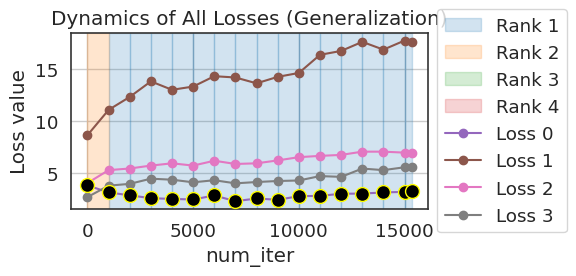

========= Sample ID: jsmbe@@Annual59/Abstract/Annual59_230_sentid:2 =========
Context: Mechanical forces that cells actively generate play a key role in forming the tissue structures.
Sentence Position: 2
Cloze Query: [BLANK] play a key role in forming the tissue structures.
Paraphrase: What type of forces are crucial for the formation of tissue structures?
Options: 
Hormonal signals released by endocrine glands
Mechanical forces actively generated by cells
Chemical gradients produced by cells
Electrical signals transmitted by neurons
Answer: 1


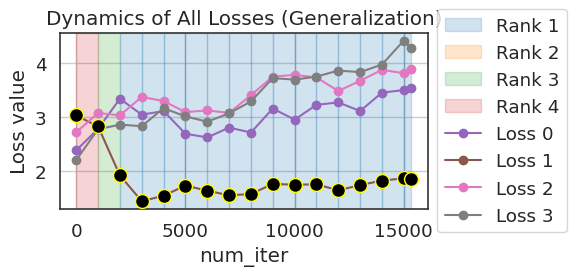

========= Sample ID: jrrsabst@@2009/0/2009_0_99_2_sentid:4 =========
Context: The SYCE2 protein is a component of the central elements of the synaptonemal complex, a meiosis-specific supramolecular proteinaceous structure that is essential for synapsis of the maternal and paternal homologous chromosomes.
Sentence Position: 4
Cloze Query: The [BLANK] is a component of the central elements of the synaptonemal complex, a meiosis-specific supramolecular proteinaceous structure that is essential for synapsis of the maternal and paternal homologous chromosomes.
Paraphrase: Which protein is part of the central elements of the synaptonemal complex, a structure required for chromosome synapsis during meiosis?
Options: 
SYCE2 protein
RAD51 protein
CENP-A protein
SMC1 protein
Answer: 0


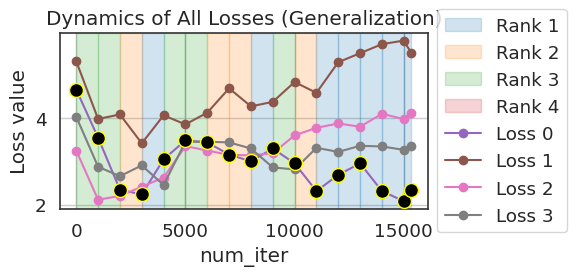

========= Sample ID: jjscc1962@@21/1/21_1_26_sentid:0 =========
Context: Pulmonary hamartoma is one of the common benign tumors in lungs.
Sentence Position: 0
Cloze Query: [BLANK] is one of the common benign tumors in lungs.
Paraphrase: Which tumor is frequently found as a benign growth in the lungs?
Options: 
Bronchogenic carcinoma
Pulmonary hamartoma
Pulmonary adenoma
Pleural mesothelioma
Answer: 1


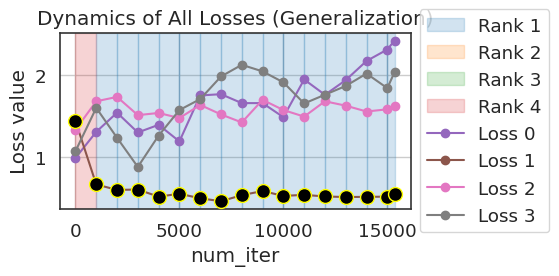

========= Sample ID: jjabcs1992@@15/2/15_2_191_sentid:1 =========
Context: The original BI-RADS devised in the USA defines 7-step final assessment categories from 0 to 6 and each category clearly indicates subsequent management ; category 1 is defined as no abnormal findings, category 2 benign findings, category 3 probably benign findings and a 6-month interval follow-up is suggested, and categories 4 and 5, suspicious abnormality and highly suggestive of malignancy, respectively, both requiring needle biopsy or appropriate action.
Sentence Position: 1
Cloze Query: The original BI-RADS devised in the USA defines [BLANK], and each category clearly indicates subsequent management.
Paraphrase: What does the original BI-RADS system define, and how are management recommendations incorporated?
Options: 
4 diagnostic levels from A to D, each with optional follow-up suggestions
5-step risk categories from 1 to 5, each with general screening advice
7-step final assessment categories from 0 to 6

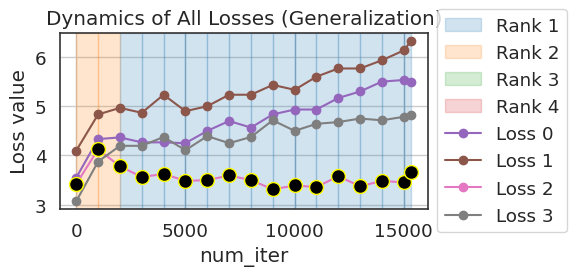

========= Sample ID: kenbikyo@@44/3/44_179_sentid:0 =========
Context: In eukaryotes, the actin cytoskeleton plays important roles in polarized cell growth and cytokinesis.
Sentence Position: 0
Cloze Query: In eukaryotes, the actin cytoskeleton plays important roles in [BLANK].
Paraphrase: Which cellular processes in eukaryotes depend on the actin cytoskeleton for their proper function?
Options: 
protein synthesis and vesicle trafficking
mitochondrial energy production and apoptosis
DNA replication and transcription
polarized cell growth and cytokinesis
Answer: 3


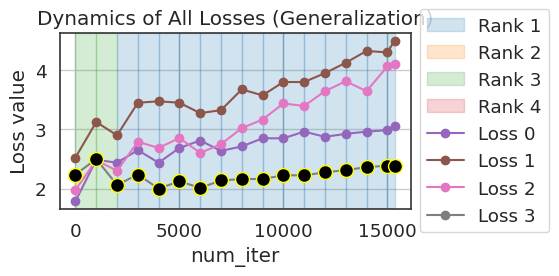

========= Sample ID: ojjscn1969@@34/2/34_2_147_sentid:2 =========
Context: The pulsed Doppler system (PD) in combination with PF can selectively visualize small vessels and slow blood flow, such as the steady flow conditions of the lenticulostriate artery (LSA).
Sentence Position: 2
Cloze Query: The pulsed Doppler system (PD) in combination with PF can selectively visualize [BLANK].
Paraphrase: What types of blood flow and vessels can be selectively visualized using the pulsed Doppler system (PD) together with PF?
Options: 
capillary networks and intermittent blood flow, such as in the skin microvasculature
large arteries and rapid blood flow, such as the carotid artery
venous structures and turbulent blood flow, such as the jugular vein
small vessels and slow blood flow, such as the steady flow conditions of the lenticulostriate artery (LSA)
Answer: 3


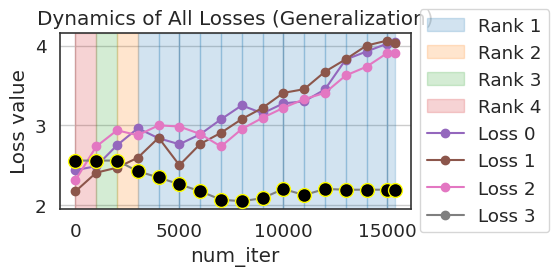

========= Sample ID: jsao1972@@22/2/22_2_339_sentid:2 =========
Context: Hydroxyapatite particles (HAp) contains many micropores and extensive surface areas.
Sentence Position: 2
Cloze Query: [BLANK] contains many micropores and extensive surface areas.
Paraphrase: Which type of particles are characterized by having many micropores and extensive surface areas?
Options: 
Titanium dioxide particles
Hydroxyapatite particles (HAp)
Silica nanoparticles
Zirconia ceramics
Answer: 1


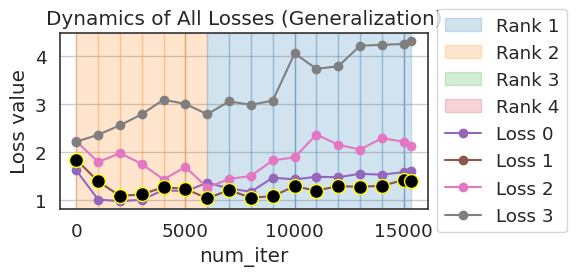

========= Sample ID: shokueishi1960@@31/5/31_5_394_sentid:0 =========
Context: The sweetening agents isomaltooligosaccharides (IMO), derived from cornstarch, are known to be a growth factor of Bifidobacterium.
Sentence Position: 0
Cloze Query: The sweetening agents isomaltooligosaccharides (IMO), derived from cornstarch, are known to be a growth factor of [BLANK].
Paraphrase: Which microorganism's growth is promoted by isomaltooligosaccharides (IMO) derived from cornstarch?
Options: 
Streptococcus
Escherichia coli
Bifidobacterium
Lactobacillus
Answer: 2


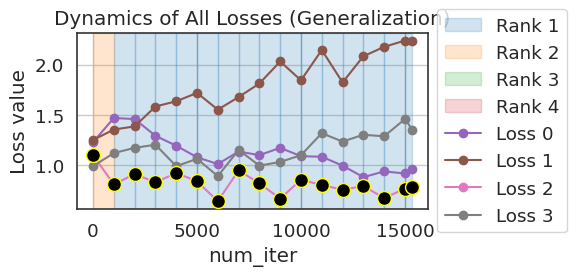

========= Sample ID: kanzo1960@@27/10/27_10_1412_sentid:3 =========
Context: Frequency and time of beginning opacification of the hepatic vein were closely correlated with the degree of intrahepatic shunt.
Sentence Position: 3
Cloze Query: Frequency and time of beginning opacification of the hepatic vein were closely correlated with [BLANK].
Paraphrase: With which clinical parameter are the frequency and timing of initial hepatic vein opacification closely associated?
Options: 
level of liver enzyme elevation
severity of portal hypertension
degree of intrahepatic shunt
extent of hepatic fibrosis
Answer: 2


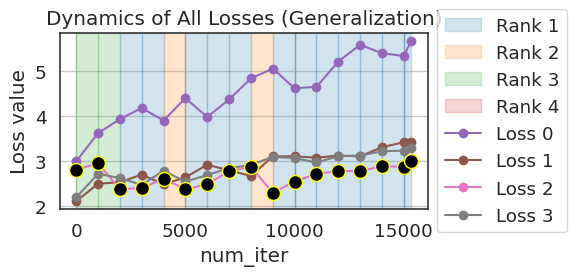

In [187]:
# sample_id = 9
# display_sample(ja_keys[sample_id], lang="ja")
# # display_loss_dynamics(ja_mem_id2losses[ja_keys[sample_id]], type="mem")
# display_loss_dynamics(ja_gen_id2losses[ja_keys[sample_id]], type="gen")
# display_loss_dynamics(en2ja_gen_id2losses[ja_keys[sample_id]], type="gen")

    # display_loss_dynamics(ja_mem_id2losses[ja_keys[sample_id]], type="mem")
for sample_id in list(en_gen_id2losses.keys())[10:20]:
    print(f"========= Sample ID: {sample_id} =========")
    display_sample(sample_id, lang="en")
    display_loss_dynamics(en_gen_id2losses[sample_id], type="gen")

Context: ヒト免疫不全ウイルス (Human immunode6ciency virus: HIV) 感染症に発症する呼吸器感染症ではカリニ肺炎がもっとも重要である。
Sentence Position: 0
Cloze Query: ヒト免疫不全ウイルス (HIV) 感染症に発症する呼吸器感染症では[BLANK]がもっとも重要である。
Paraphrase: HIV感染症で発症する呼吸器感染症の中で最も重要とされる疾患は何ですか？
Options: 
結核性肺炎
カリニ肺炎
サイトメガロウイルス肺炎
細菌性肺炎
Answer: 1


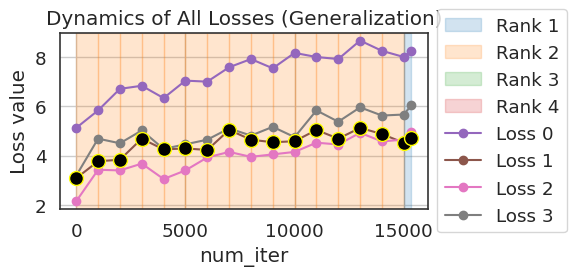

Context: 日本のsperatus-likespecies complexは幾つかのタクサに分けられ,その一つは主に日本の北半分に,他方は南半分に分布する。
Sentence Position: 7
Cloze Query: 日本の[BLANK]は幾つかのタクサに分けられ、その一つは主に日本の北半分に、他方は南半分に分布する。
Paraphrase: 日本の北半分と南半分に分布が分かれる地理的分布パターンを示すのはどの分類群ですか？
Options: 
クシヒゲシロアリ属
ヤマトシロアリ属
speratus-like species complex
アカイエカ種群
Answer: 2


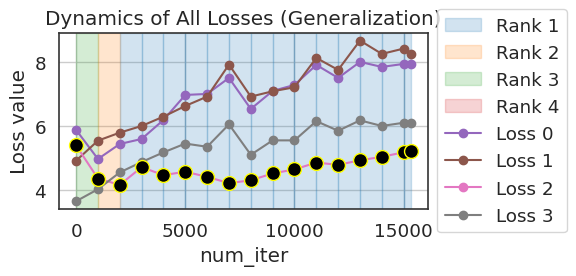

Context: 固有筋層(pm層)発生の平滑筋腫並びに平滑筋肉腫についても,pm層と病変との連続性を指摘することにより容易に診断でき,さらに腫瘍径の客観的描出も可能であった.
Sentence Position: 5
Cloze Query: [BLANK]により固有筋層(pm層)発生の平滑筋腫並びに平滑筋肉腫は容易に診断でき、さらに腫瘍径の客観的描出も可能であった。
Paraphrase: 固有筋層（pm層）発生の平滑筋腫および平滑筋肉腫を容易に診断するために重要な所見は何ですか？
Options: 
腫瘍の境界明瞭性のみを確認すること
腫瘍周囲の血管分布を評価すること
pm層と病変との連続性を指摘すること
腫瘍の表面の色調変化を観察すること
Answer: 2


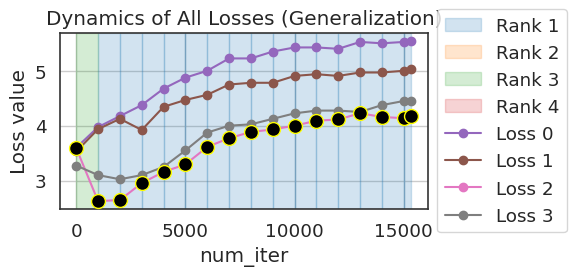

Context: 副腎髄質から分泌されるカテコールアミン (CA) は, 循環や血糖調節に関与する重要なホルモンであり, 交感神経によりその分泌が調節されている.
Sentence Position: 0
Cloze Query: [BLANK]は、循環や血糖調節に関与する重要なホルモンであり、交感神経によりその分泌が調節されている。
Paraphrase: 循環や血糖調節に関与し、交感神経によって分泌が調節されるホルモンは何ですか？
Options: 
副腎皮質から分泌されるコルチゾール
膵臓から分泌されるインスリン
甲状腺から分泌されるサイロキシン
副腎髄質から分泌されるカテコールアミン（CA）
Answer: 3


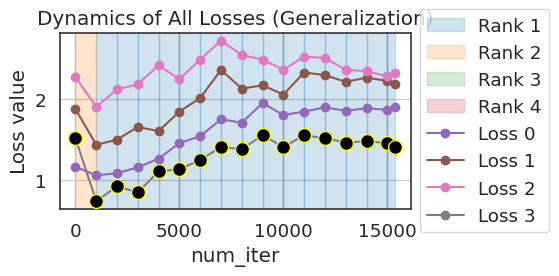

Context: 細胞に予め低線量放射線を照射すると、その後の高線量放射線に対する細胞死、染色体異常、突然変異の頻度が減少することが知られており、放射線適応応答と呼ばれている。
Sentence Position: 0
Cloze Query: 細胞に予め[BLANK]を照射すると、その後の高線量放射線に対する細胞死、染色体異常、突然変異の頻度が減少することが知られており、放射線適応応答と呼ばれている。
Paraphrase: その後の高線量放射線に対する細胞死や染色体異常、突然変異の頻度を減少させるために細胞に予め照射されるのは何ですか？
Options: 
高線量放射線
紫外線
化学薬品
低線量放射線
Answer: 3


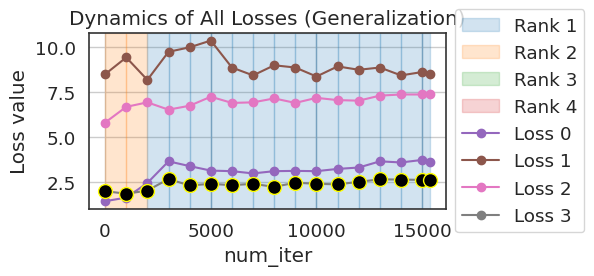

Context: 尿管の摘出方法は Transurethral ureteral pull through (経尿道的尿管引き抜き術) と Transurethral ureteral resection (経尿道的尿管切除術) の2方法である.
Sentence Position: 2
Cloze Query: 尿管の摘出方法には[BLANK]の2方法がある。
Paraphrase: 尿管の摘出方法として用いられる2つの術式は何ですか？
Options: 
Endoscopic ureteral ligation（内視鏡的尿管結紮術）とRetrograde ureteral stenting（逆行性尿管ステント留置術）
Transurethral ureteral pull through（経尿道的尿管引き抜き術）とTransurethral ureteral resection（経尿道的尿管切除術）
Transabdominal ureteral resection（経腹的尿管切除術）とPercutaneous ureteral ablation（経皮的尿管アブレーション）
Laparoscopic ureterectomy（腹腔鏡下尿管摘出術）とOpen ureteral resection（開腹尿管切除術）
Answer: 1


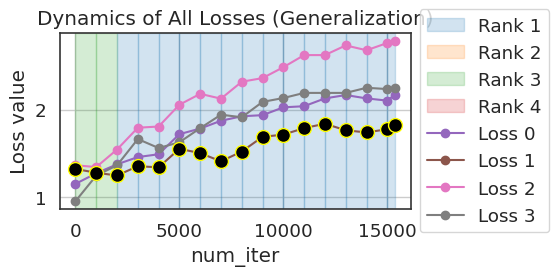

Context: 回転や剪断力により, 脳実質軸索に障害をきたしたものを, 外傷性軸索損傷という。
Sentence Position: 3
Cloze Query: 回転や剪断力により、脳実質軸索に障害をきたしたものを[BLANK]という。
Paraphrase: 回転や剪断力によって脳実質軸索に障害が生じた状態は何と呼ばれますか？
Options: 
脳内出血
慢性硬膜下血腫
脳挫傷
外傷性軸索損傷
Answer: 3


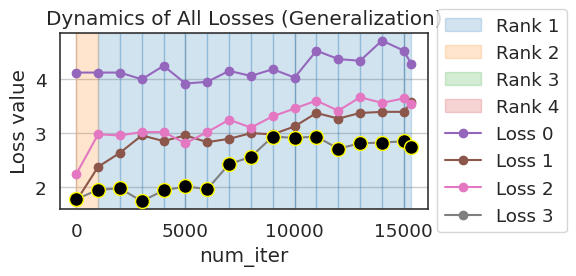

Context: 色素性乾皮症は常染色体性劣性遺伝様式の遺伝性疾患であり,患者の多くに皮膚がんが生じる。
Sentence Position: 1
Cloze Query: [BLANK]は常染色体性劣性遺伝様式の遺伝性疾患であり、患者の多くに皮膚がんが生じる。
Paraphrase: 常染色体性劣性遺伝様式の遺伝性疾患であり、患者の多くに皮膚がんが生じる疾患は何ですか？
Options: 
結節性硬化症
色素性乾皮症
ハンチントン病
白皮症
Answer: 1


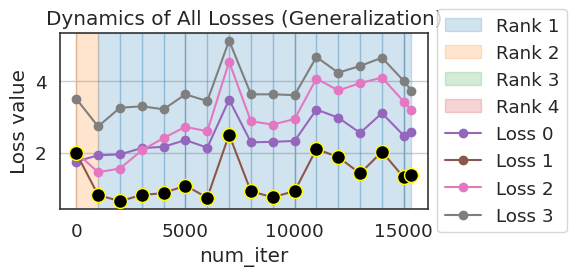

Context: コンピュータ断層撮影(Computed tomography; CT)検査は、物体を透過したX線の量を測定し、その断面画像を得る検査であり、一般に造影剤を使用しない単純検査と、造影剤を使用する造影検査がある。
Sentence Position: 0
Cloze Query: コンピュータ断層撮影(CT)検査は、物体を透過したX線の量を測定し、その断面画像を得る検査であり、一般に[BLANK]と、造影剤を使用する造影検査がある。
Paraphrase: CT検査において、造影剤を使用しない検査方法は何と呼ばれますか？
Options: 
核磁気共鳴画像検査
超音波検査
単純検査
動脈造影検査
Answer: 2


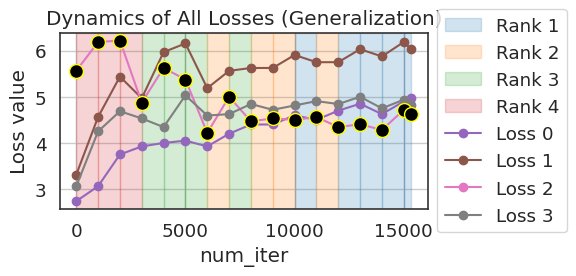

Context: Petersen's herniaは胃切除Roux-en-Y再建後に挙上空腸と横行結腸間膜の間隙(Petersen's defect)をヘルニア門として起こる内ヘルニアである.
Sentence Position: 0
Cloze Query: Petersen's herniaは[BLANK]をヘルニア門として起こる内ヘルニアである。
Paraphrase: Petersen's herniaが発生する際、ヘルニア門となるのはどの部位ですか？
Options: 
胃切除後の横行結腸と脾彎曲部間の間隙
胃切除Roux-en-Y再建後に挙上空腸と横行結腸間膜の間隙（Petersen's defect）
胃切除Roux-en-Y再建後の空腸と回腸間膜の間隙
胃切除Billroth I再建後の幽門部と十二指腸間の間隙
Answer: 1


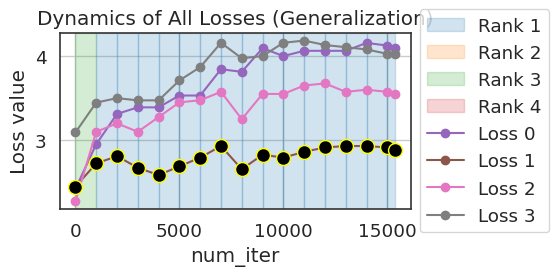

In [174]:
for sample_id in list(en2ja_gen_id2losses.keys())[:10]:
    display_sample(sample_id, lang="ja")
    display_loss_dynamics(en2ja_gen_id2losses[sample_id], type="gen")

In [206]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

def display_loss_dynamics_three(results_list, titles):
    """
    Display vertically stacked loss dynamics for three result sets
    with shared x-axis and a single legend on the right.
    """
    assert len(results_list) == 3, "Expected three sets of results."
    assert len(titles) == 3, "Provide three subplot titles."

    rank_colors = {
        1: "#1f77b4",
        2: "#ff7f0e",
        3: "#2ca02c",
        4: "#d62728",
    }
    line_colors = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

    # Slightly wider figure to make space for legend
    fig, axes = plt.subplots(3, 1, figsize=(5, 4.2), sharex=True)

    for ax, results, title in zip(axes, results_list, titles):
        num_points = len(results[0]['norm_loss'])
        iters = [res['num_iter'] for res in results]
        losses_array = np.array([res['norm_loss'] for res in results])

        ranks = []
        for res in results:
            losses = np.array(res['norm_loss'])
            ans_idx = res['answer_idx']
            rank = losses.argsort().tolist().index(ans_idx) + 1
            ranks.append(rank)

        # background shading
        for i in range(len(iters) - 1):
            ax.axvspan(iters[i], iters[i+1], color=rank_colors[ranks[i]], alpha=0.2)

        # plot loss lines
        for idx in range(num_points):
            ax.plot(iters, losses_array[:, idx], color=line_colors[idx], marker='o', linewidth=1.8)

        # highlight correct answer
        for i, res in enumerate(results):
            ans_idx = res['answer_idx']
            ax.scatter(iters[i], losses_array[i, ans_idx],
                       color='black', s=50, edgecolor='yellow', zorder=5)

        ax.set_ylabel("Loss", fontsize=13)
        ax.set_title(title, fontsize=12.5, pad=2)
        ax.set_ylim(1, 6)
        ax.grid(True, linestyle='--', alpha=0.4)

    # Shared x-axis formatting
    axes[-1].set_xlabel("Iteration Number", fontsize=13)
    axes[-1].set_xlim(iters[0]-400, iters[-1]+400)
    axes[-1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '0' if x == 0 else f'{int(x/1000)}K'))

    # === Right-side legends ===
    legend_patches = [Patch(color=rank_colors[r], alpha=0.2, label=f"Rank {r}") for r in sorted(rank_colors)]
    legend_lines = [plt.Line2D([0], [0], color=line_colors[i], marker='o', label=f"Loss {i}") for i in range(len(line_colors))]

    fig.legend(
        handles=legend_patches,
        title="Rank of\nCorrect\nAnswer",
        loc="center left",
        bbox_to_anchor=(0.8, 0.72),
        fontsize=11,
        title_fontsize=11.5,
        handlelength=1.3
    )
    fig.legend(
        handles=legend_lines,
        title="Losses of\ni-th Option",
        loc="center left",
        bbox_to_anchor=(0.8, 0.33),
        fontsize=11,
        title_fontsize=11.5,
        handlelength=1.3
    )

    # === Adjust subplot spacing ===
    plt.subplots_adjust(
        left=0.12,   # tighter left margin
        right=0.78,  # leave room for legend
        top=0.97,
        bottom=0.10,
        hspace=0.2  # << controls vertical gap between panels
    )

    # plt.show()
    plt.savefig(os.path.join("../figures", "loss-instance-check.pdf"),dpi=300, bbox_inches="tight")


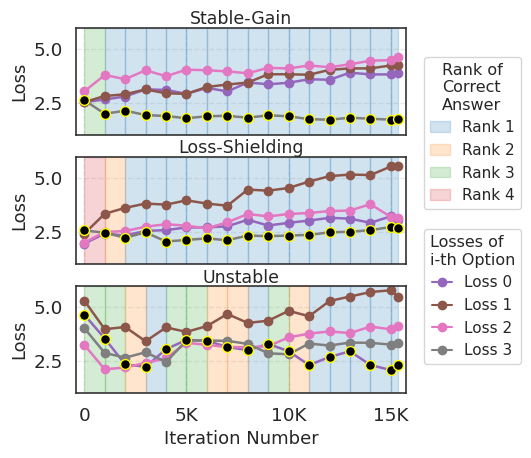

In [210]:
sample_ids = list(en_gen_id2losses.keys())[:3]
sample_ids = ["jrrsabst@@2011/0/2011_0_258_sentid:0", "aohc1950@@42/3/42_3_375_sentid:7", "jrrsabst@@2009/0/2009_0_99_2_sentid:4"]
display_loss_dynamics_three(
    [en_gen_id2losses[sample_id] for sample_id in sample_ids], 
    titles=["Stable-Gain", "Loss-Shielding", "Unstable"])

In [189]:
display_loss_dynamics_three[]

SyntaxError: invalid syntax (4270329227.py, line 1)

In [62]:
doc_index.min(), doc_index.max()

(np.int32(0), np.int32(3461201))

In [58]:
from tqdm import tqdm 
num_docs = 3461202
num_epochs = 4

doc_id = ja_keys[sample_id].split(":")[0][:-7]
instruction_filename = "/data/xzhao/dataset/roman-pretrain/instructions/ja/medical_native.jsonl"
train_data_indexes = []
for idx, item in tqdm(enumerate(load_jsonl_iteratively(instruction_filename, request_num=num_docs))):
    if doc_id == item['docid']:
        train_data_indexes.append(idx)
        matched = True
    else:
        matched = False
    if len(train_data_indexes) > 0 and not matched:
        break
print(train_data_indexes)

80606it [00:01, 40944.07it/s]

[80599, 80600, 80601, 80602, 80603, 80604, 80605]


In [64]:
doc_poses = [doc_pos for doc_pos, i in enumerate(doc_index) if i in train_data_indexes]

In [68]:
i = 0
batch_poses = []
for _idx, ((beg_doc, _), (end_doc, _)) in enumerate(zip(sample_index[:-1], sample_index[1:])): 
    if i > len(doc_poses) - 1:
        break
    if end_doc > doc_poses[i] and beg_doc > doc_poses[i]:
        i += 1
        batch_poses.append(_idx)

In [69]:
true_batch_poses = []
for train_index, batch_idx in enumerate(shuffle_index.tolist()):
    if batch_idx in batch_poses: 
        true_batch_poses.append(train_index / 32)
true_batch_poses

[38.875,
 391.65625,
 903.96875,
 1962.875,
 2003.09375,
 2338.5,
 2827.0625,
 3234.4375,
 3417.9375,
 3649.6875,
 3685.53125,
 4023.21875,
 4069.6875,
 5612.65625,
 5983.53125,
 7062.40625,
 8550.21875,
 8893.65625,
 9489.40625,
 10064.375,
 10451.59375,
 13171.65625,
 13179.40625,
 13681.0625,
 13820.71875,
 13925.1875,
 14911.6875,
 15014.34375,
 15830.21875,
 16023.375,
 16502.875,
 17261.125,
 17963.375,
 18299.53125,
 18421.78125]

In [56]:
train_pos

[3081.34375, 6670.5, 7969.3125, 11322.84375, 12747.21875, 13685.96875]